**Installing Pyspark**

In [2]:
!pip install pyspark

In [3]:
pip install scikit-learn

**LOAD AND INSPECT THE DATA**

In [1]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("IplCricketAnalysis").getOrCreate()

# Load CSV file
file_path = "df_batting.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the first few rows of the DataFrame
df.show(5)

# Print the schema to understand the structure of the data
df.printSchema()


+--------------------+-----------+----------+--------------------+----+-----+---+---+------+-----------+-----------+
|               match|teamInnings|battingPos|         batsmanName|runs|balls| 4s| 6s|    SR|out/not_out|   match_id|
+--------------------+-----------+----------+--------------------+----+-----+---+---+------+-----------+-----------+
|Namibia Vs Sri Lanka|    Namibia|         1|  Michael van Lingen|   3|    6|  0|  0| 50.00|        out|T20I # 1823|
|Namibia Vs Sri Lanka|    Namibia|         2|       Divan la Cock|   9|    9|  1|  0|100.00|        out|T20I # 1823|
|Namibia Vs Sri Lanka|    Namibia|         3|Jan Nicol Loftie-...|  20|   12|  1|  2|166.66|        out|T20I # 1823|
|Namibia Vs Sri Lanka|    Namibia|         4|       Stephan Baard|  26|   24|  2|  0|108.33|        out|T20I # 1823|
|Namibia Vs Sri Lanka|    Namibia|         5|  Gerhard Erasmus(c)|  20|   24|  0|  0| 83.33|        out|T20I # 1823|
+--------------------+-----------+----------+-------------------

**Performing EXPLORATORY DATA ANALYSIS (EDA)**

In [4]:
from pyspark.sql.functions import count, when, col

# Check for missing values in each column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+-----+-----------+----------+-----------+----+-----+---+---+---+-----------+--------+
|match|teamInnings|battingPos|batsmanName|runs|balls| 4s| 6s| SR|out/not_out|match_id|
+-----+-----------+----------+-----------+----+-----+---+---+---+-----------+--------+
|    0|          0|         0|          0|   0|    0|  0|  0|  0|          0|       0|
+-----+-----------+----------+-----------+----+-----+---+---+---+-----------+--------+



**DATA CLEANING**

In [5]:
# Drop rows with missing values
df_clean = df.dropna()

# Remove duplicates
df_clean = df_clean.dropDuplicates()


**DATA VISUALIZATION using Histograms**



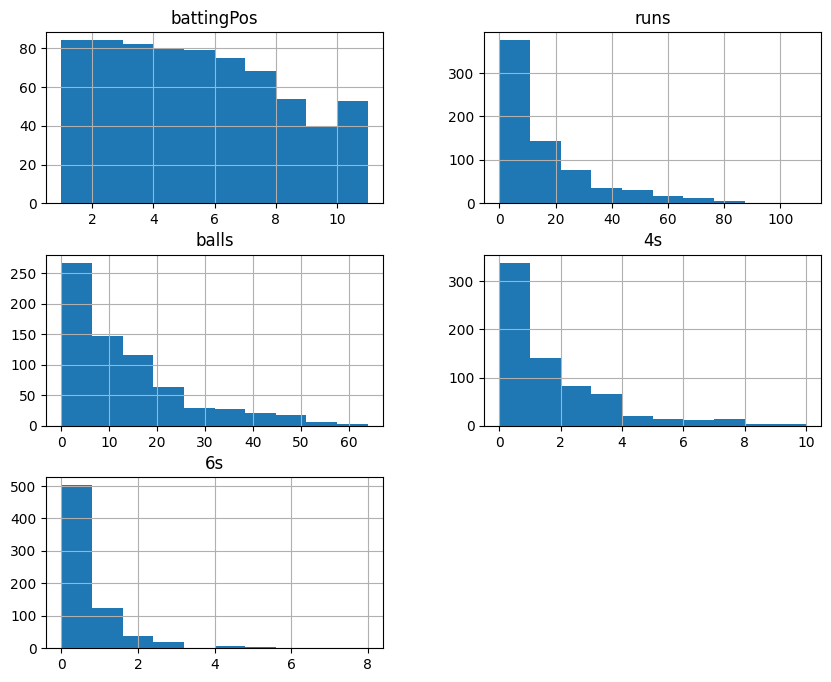

In [6]:
import matplotlib.pyplot as plt

pandas_df = df_clean.toPandas()

pandas_df.hist(figsize=(10, 8))
plt.show()


**DESCRIPTIVE ANALYTICS**

In [8]:
# Group by batsman name and calculate the average of key statistics
avg_stats_by_batsman = df.groupBy('batsmanName').agg({
    'runs': 'avg',
    'balls': 'avg',
    '4s': 'avg',
    '6s': 'avg',
    'SR': 'avg'
})

# Sort by average runs in descending order
avg_stats_by_batsman_sorted = avg_stats_by_batsman.orderBy('avg(runs)', ascending=False)

# Display the top 20 batsmen by average runs
avg_stats_by_batsman_sorted.show(20)


+--------------------+------------------+------------------+------------------+------------------+------------------+
|         batsmanName|         avg(runs)|           avg(4s)|        avg(balls)|           avg(6s)|           avg(SR)|
+--------------------+------------------+------------------+------------------+------------------+------------------+
|         Virat Kohli|49.333333333333336| 4.166666666666667|36.166666666666664|1.3333333333333333|129.85833333333335|
|       George Munsey|40.333333333333336| 5.333333333333333|35.333333333333336|               0.0| 93.46666666666665|
|      Glenn Phillips|              40.2|               3.8|              25.4|               1.6|            143.72|
|    Suryakumar Yadav|39.833333333333336| 4.333333333333333|              21.0|               1.5|182.58333333333334|
|        Brandon King|              39.5|               4.5|              31.5|               0.5|           121.245|
|    Jos Buttler(c)â€|              37.5|               

In [9]:
# Similarly, sort by other columns (e.g., average Strike Rate)
avg_sr_by_batsman = df.groupBy('batsmanName').agg({'SR': 'avg'}).orderBy('avg(SR)', ascending=False)

# Display the top 20 batsmen by average Strike Rate
avg_sr_by_batsman.show(20)


+-------------------+------------------+
|        batsmanName|           avg(SR)|
+-------------------+------------------+
|        Lungi Ngidi|             400.0|
|        Tim Southee|             225.0|
|      Anrich Nortje|             210.0|
|     Arshdeep Singh|             200.0|
|   Suryakumar Yadav|182.58333333333334|
|  Paul van Meekeren|            168.25|
|        Naseem Shah|            166.66|
|       Chris Woakes|            166.66|
|      Glenn Maxwell|161.21249999999998|
|     Marcus Stoinis|          159.2025|
|        Shadab Khan|           156.792|
|Shaheen Shah Afridi| 155.5533333333333|
|     Mohammad Haris|             152.2|
|        Dawid Malan|            151.53|
|         Finn Allen|           150.476|
|  Mustafizur Rahman|             150.0|
|      Cameron Green|             150.0|
|Regis Chakabva(c)â€|            144.44|
|          Tim David|            143.75|
|     Glenn Phillips|            143.72|
+-------------------+------------------+
only showing top

**PREDICTIVE ANALYSIS**




In [10]:
# Import necessary libraries
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

# Convert the 'SR' column to numeric type (float), replacing invalid values with None (NaN)
df_clean = df_clean.withColumn("SR", col("SR").cast("float"))

# Handle any NaN values (optional), for example by replacing NaN values with 0
df_clean = df_clean.na.fill({"SR": 0})

# Feature Engineering: Combine relevant columns into a single feature vector
assembler = VectorAssembler(
    inputCols=["runs", "balls", "4s", "6s", "SR"],  # Ensure these columns are numeric
    outputCol="features"
)

# Transform the dataset to include the features vector
data = assembler.transform(df_clean)

# Apply KMeans Clustering
kmeans = KMeans().setK(3).setSeed(1)  # Adjust the number of clusters as needed
model = kmeans.fit(data)

# Predict clusters and add them to the dataset
clusters = model.transform(data)

# Show the clustered results for relevant columns and predicted clusters
clusters.select("batsmanName", "runs", "balls", "4s", "6s", "SR", "prediction").show(20)


+-----------------+----+-----+---+---+------+----------+
|      batsmanName|runs|balls| 4s| 6s|    SR|prediction|
+-----------------+----+-----+---+---+------+----------+
|  Colin Ackermann|   0|    2|  0|  0|   0.0|         0|
|  George Dockrell|  39|   27|  4|  1|144.44|         1|
|   Shamarh Brooks|   0|    3|  0|  0|   0.0|         0|
|   Mitchell Starc|   4|    7|  0|  0| 57.14|         0|
|    Aiden Markram|  10|   11|  1|  0|  90.9|         2|
|   Mitchell Marsh|  45|   30|  3|  2| 150.0|         1|
| Dasun Shanaka(c)|   3|    8|  0|  0|  37.5|         0|
|      Shan Masood|  38|   28|  2|  1|135.71|         1|
|  Pathum Nissanka|  10|   10|  2|  0| 100.0|         2|
|    Gareth Delany|  24|   20|  1|  1| 120.0|         2|
|        Ryan Burl|   2|    7|  0|  0| 28.57|         0|
|    Sean Williams|  11|   18|  0|  1| 61.11|         2|
|   Mohammad Haris|  30|   26|  2|  1|115.38|         2|
|      Josh Little|   7|   11|  1|  0| 63.63|         2|
|      Dawid Malan|  35|   37| 

**SAVE OR EXPORT THE RESULT**

In [11]:
df_clean.write.csv("db_batting.csv")